In [1]:
import os
from utils import current_dir
os.chdir(os.path.dirname(current_dir))

import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

In [4]:
# Feel free to play with this cell
import tensorflow.keras.layers as layers


def my_model(X,y,is_training):
    """ https://github.com/tensorflow/tensorflow/blob/2b96f3662bd776e277f86997659e61046b56c315/tensorflow/python/keras/applications/vgg16.py#L40 """
    img_input = layers.Input(tensor=X)
    
    # Block 1
    x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv1')(
          img_input)
    x = layers.Conv2D(
      64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(
      128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
    x = layers.Conv2D(
      256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    # Block 5
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
    x = layers.Conv2D(
      512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Classification block
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(4096, activation='relu', name='fc1')(x)
    x = layers.Dense(4096, activation='relu', name='fc2')(x)
    
    classifier_activation = None
    x = layers.Dense(10, activation=classifier_activation, name='predictions')(x)
    return x


tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(
    onehot_labels=tf.one_hot(y, 10), logits=y_out
)
mean_loss = tf.reduce_mean(total_loss)

# # l2 regularization.
# trainable_vars = tf.trainable_variables()
# l2_loss = tf.add_n([
#     tf.nn.l2_loss(v) for v in trainable_vars if 'bias' not in v.name
# ]) * 0.001
# mean_loss += l2_loss

optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(mean_loss)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Training
Iteration 0: with minibatch training loss = 2.31 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.99 and accuracy of 0.2
Iteration 200: with minibatch training loss = 2.07 and accuracy of 0.31
Iteration 300: with minibatch training loss = 1.72 and accuracy of 0.31
Iteration 400: with minibatch training loss = 1.78 and accuracy of 0.36
Iteration 500: with minibatch training loss = 1.39 and accuracy of 0.42
Iteration 600: with minibatch training loss = 1.55 and accuracy of 0.48
Iteration 700: with minibatch training loss = 1.55 and accuracy of 0.44
Epoch 1, Overall loss = 1.71 and accuracy of 0.34


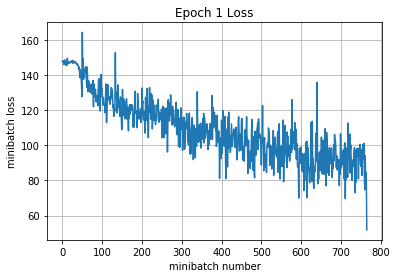

Iteration 800: with minibatch training loss = 1.33 and accuracy of 0.56
Iteration 900: with minibatch training loss = 1.4 and accuracy of 0.53
Iteration 1000: with minibatch training loss = 1.41 and accuracy of 0.55
Iteration 1100: with minibatch training loss = 0.904 and accuracy of 0.69
Iteration 1200: with minibatch training loss = 0.991 and accuracy of 0.69
Iteration 1300: with minibatch training loss = 1.02 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 0.929 and accuracy of 0.69
Iteration 1500: with minibatch training loss = 1.19 and accuracy of 0.56
Epoch 2, Overall loss = 1.18 and accuracy of 0.569


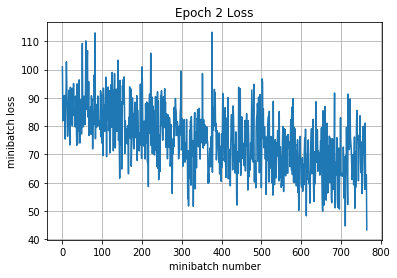

Iteration 1600: with minibatch training loss = 0.772 and accuracy of 0.72
Iteration 1700: with minibatch training loss = 0.816 and accuracy of 0.69
Iteration 1800: with minibatch training loss = 0.96 and accuracy of 0.72
Iteration 1900: with minibatch training loss = 0.882 and accuracy of 0.75
Iteration 2000: with minibatch training loss = 0.893 and accuracy of 0.66
Iteration 2100: with minibatch training loss = 0.805 and accuracy of 0.69
Iteration 2200: with minibatch training loss = 0.836 and accuracy of 0.69
Epoch 3, Overall loss = 0.899 and accuracy of 0.68


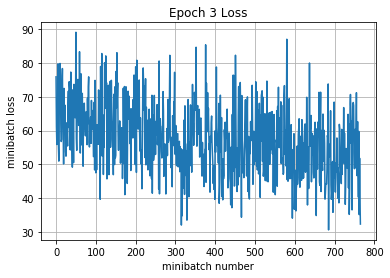

Iteration 2300: with minibatch training loss = 0.673 and accuracy of 0.78
Iteration 2400: with minibatch training loss = 0.5 and accuracy of 0.81
Iteration 2500: with minibatch training loss = 0.56 and accuracy of 0.84
Iteration 2600: with minibatch training loss = 0.642 and accuracy of 0.8
Iteration 2700: with minibatch training loss = 0.699 and accuracy of 0.72
Iteration 2800: with minibatch training loss = 0.951 and accuracy of 0.67
Iteration 2900: with minibatch training loss = 0.573 and accuracy of 0.81
Iteration 3000: with minibatch training loss = 0.465 and accuracy of 0.84
Epoch 4, Overall loss = 0.708 and accuracy of 0.752


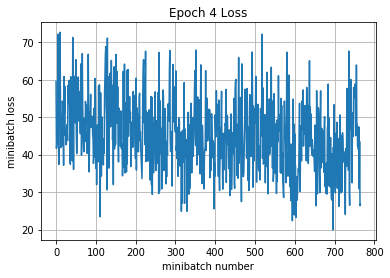

Iteration 3100: with minibatch training loss = 0.377 and accuracy of 0.91
Iteration 3200: with minibatch training loss = 0.721 and accuracy of 0.72
Iteration 3300: with minibatch training loss = 0.389 and accuracy of 0.84
Iteration 3400: with minibatch training loss = 0.348 and accuracy of 0.86
Iteration 3500: with minibatch training loss = 0.552 and accuracy of 0.84
Iteration 3600: with minibatch training loss = 0.558 and accuracy of 0.81
Iteration 3700: with minibatch training loss = 0.511 and accuracy of 0.8
Iteration 3800: with minibatch training loss = 0.516 and accuracy of 0.78
Epoch 5, Overall loss = 0.567 and accuracy of 0.805


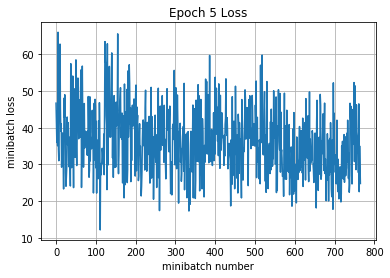

Iteration 3900: with minibatch training loss = 0.373 and accuracy of 0.89
Iteration 4000: with minibatch training loss = 0.417 and accuracy of 0.86
Iteration 4100: with minibatch training loss = 0.653 and accuracy of 0.77
Iteration 4200: with minibatch training loss = 0.479 and accuracy of 0.81
Iteration 4300: with minibatch training loss = 0.237 and accuracy of 0.92
Iteration 4400: with minibatch training loss = 0.538 and accuracy of 0.84
Iteration 4500: with minibatch training loss = 0.482 and accuracy of 0.88
Epoch 6, Overall loss = 0.466 and accuracy of 0.842


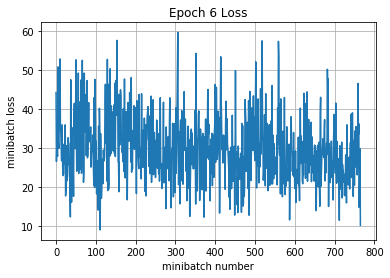

Iteration 4600: with minibatch training loss = 0.44 and accuracy of 0.86
Iteration 4700: with minibatch training loss = 0.263 and accuracy of 0.91
Iteration 4800: with minibatch training loss = 0.471 and accuracy of 0.83
Iteration 4900: with minibatch training loss = 0.369 and accuracy of 0.86
Iteration 5000: with minibatch training loss = 0.575 and accuracy of 0.83
Iteration 5100: with minibatch training loss = 0.219 and accuracy of 0.91
Iteration 5200: with minibatch training loss = 0.518 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 0.422 and accuracy of 0.84
Epoch 7, Overall loss = 0.374 and accuracy of 0.874


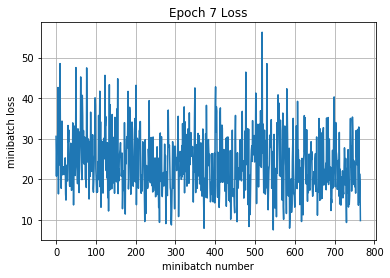

Iteration 5400: with minibatch training loss = 0.244 and accuracy of 0.92
Iteration 5500: with minibatch training loss = 0.223 and accuracy of 0.88
Iteration 5600: with minibatch training loss = 0.387 and accuracy of 0.88
Iteration 5700: with minibatch training loss = 0.272 and accuracy of 0.88
Iteration 5800: with minibatch training loss = 0.253 and accuracy of 0.92
Iteration 5900: with minibatch training loss = 0.236 and accuracy of 0.92
Iteration 6000: with minibatch training loss = 0.156 and accuracy of 0.92
Iteration 6100: with minibatch training loss = 0.325 and accuracy of 0.88
Epoch 8, Overall loss = 0.302 and accuracy of 0.897


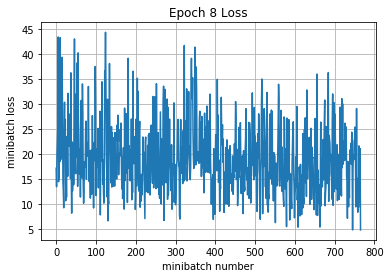

Iteration 6200: with minibatch training loss = 0.29 and accuracy of 0.91
Iteration 6300: with minibatch training loss = 0.525 and accuracy of 0.83
Iteration 6400: with minibatch training loss = 0.406 and accuracy of 0.88
Iteration 6500: with minibatch training loss = 0.0884 and accuracy of 0.98
Iteration 6600: with minibatch training loss = 0.286 and accuracy of 0.89
Iteration 6700: with minibatch training loss = 0.0681 and accuracy of 0.97
Iteration 6800: with minibatch training loss = 0.289 and accuracy of 0.92
Epoch 9, Overall loss = 0.244 and accuracy of 0.918


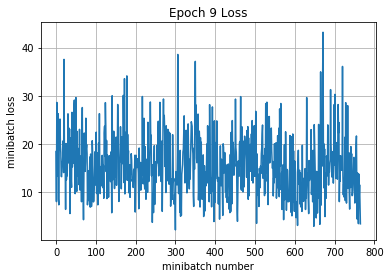

Iteration 6900: with minibatch training loss = 0.12 and accuracy of 0.95
Iteration 7000: with minibatch training loss = 0.152 and accuracy of 0.94
Iteration 7100: with minibatch training loss = 0.222 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.454 and accuracy of 0.86
Iteration 7300: with minibatch training loss = 0.216 and accuracy of 0.94
Iteration 7400: with minibatch training loss = 0.227 and accuracy of 0.92
Iteration 7500: with minibatch training loss = 0.0919 and accuracy of 0.95
Iteration 7600: with minibatch training loss = 0.18 and accuracy of 0.95
Epoch 10, Overall loss = 0.191 and accuracy of 0.936


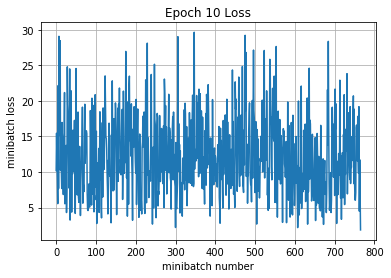

Iteration 7700: with minibatch training loss = 0.109 and accuracy of 0.95
Iteration 7800: with minibatch training loss = 0.108 and accuracy of 0.94
Iteration 7900: with minibatch training loss = 0.0324 and accuracy of 1
Iteration 8000: with minibatch training loss = 0.103 and accuracy of 0.98
Iteration 8100: with minibatch training loss = 0.104 and accuracy of 0.95
Iteration 8200: with minibatch training loss = 0.137 and accuracy of 0.97
Iteration 8300: with minibatch training loss = 0.182 and accuracy of 0.94
Iteration 8400: with minibatch training loss = 0.0431 and accuracy of 1
Epoch 11, Overall loss = 0.156 and accuracy of 0.948


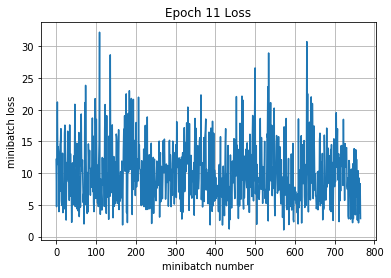

Iteration 8500: with minibatch training loss = 0.118 and accuracy of 0.97
Iteration 8600: with minibatch training loss = 0.117 and accuracy of 0.97
Iteration 8700: with minibatch training loss = 0.195 and accuracy of 0.94
Iteration 8800: with minibatch training loss = 0.0912 and accuracy of 0.97
Iteration 8900: with minibatch training loss = 0.0928 and accuracy of 0.95
Iteration 9000: with minibatch training loss = 0.192 and accuracy of 0.91
Iteration 9100: with minibatch training loss = 0.056 and accuracy of 1
Epoch 12, Overall loss = 0.133 and accuracy of 0.956


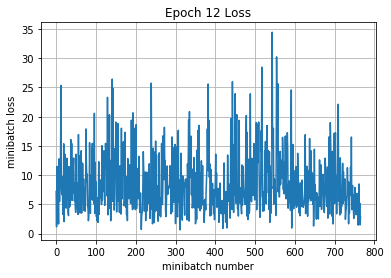

Iteration 9200: with minibatch training loss = 0.0764 and accuracy of 0.98
Iteration 9300: with minibatch training loss = 0.0354 and accuracy of 1
Iteration 9400: with minibatch training loss = 0.0646 and accuracy of 0.98
Iteration 9500: with minibatch training loss = 0.0689 and accuracy of 0.98
Iteration 9600: with minibatch training loss = 0.101 and accuracy of 0.97
Iteration 9700: with minibatch training loss = 0.126 and accuracy of 0.95
Iteration 9800: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 9900: with minibatch training loss = 0.0664 and accuracy of 0.98
Epoch 13, Overall loss = 0.119 and accuracy of 0.961


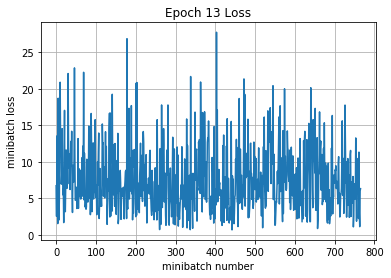

Iteration 10000: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 10100: with minibatch training loss = 0.127 and accuracy of 0.98
Iteration 10200: with minibatch training loss = 0.039 and accuracy of 0.98
Iteration 10300: with minibatch training loss = 0.1 and accuracy of 0.92
Iteration 10400: with minibatch training loss = 0.167 and accuracy of 0.94
Iteration 10500: with minibatch training loss = 0.107 and accuracy of 0.97
Iteration 10600: with minibatch training loss = 0.099 and accuracy of 0.97
Iteration 10700: with minibatch training loss = 0.187 and accuracy of 0.94
Epoch 14, Overall loss = 0.104 and accuracy of 0.966


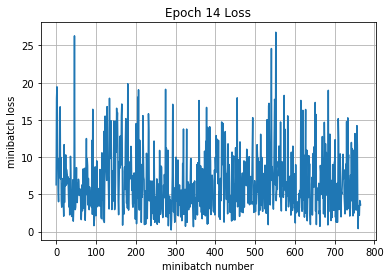

Iteration 10800: with minibatch training loss = 0.0423 and accuracy of 0.98
Iteration 10900: with minibatch training loss = 0.0736 and accuracy of 0.98
Iteration 11000: with minibatch training loss = 0.113 and accuracy of 0.97
Iteration 11100: with minibatch training loss = 0.126 and accuracy of 0.94
Iteration 11200: with minibatch training loss = 0.139 and accuracy of 0.97
Iteration 11300: with minibatch training loss = 0.0192 and accuracy of 1
Iteration 11400: with minibatch training loss = 0.0779 and accuracy of 0.98
Epoch 15, Overall loss = 0.102 and accuracy of 0.967


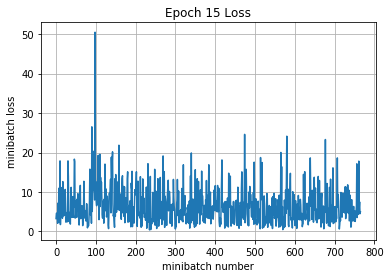

Iteration 11500: with minibatch training loss = 0.174 and accuracy of 0.94
Iteration 11600: with minibatch training loss = 0.0499 and accuracy of 1
Iteration 11700: with minibatch training loss = 0.166 and accuracy of 0.95
Iteration 11800: with minibatch training loss = 0.0494 and accuracy of 0.98
Iteration 11900: with minibatch training loss = 0.0377 and accuracy of 0.98
Iteration 12000: with minibatch training loss = 0.0307 and accuracy of 0.98
Iteration 12100: with minibatch training loss = 0.0152 and accuracy of 1
Iteration 12200: with minibatch training loss = 0.0517 and accuracy of 0.97
Epoch 16, Overall loss = 0.0899 and accuracy of 0.97


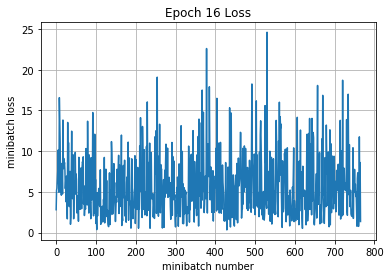

Iteration 12300: with minibatch training loss = 0.0828 and accuracy of 0.97
Iteration 12400: with minibatch training loss = 0.0252 and accuracy of 1
Iteration 12500: with minibatch training loss = 0.039 and accuracy of 0.98
Iteration 12600: with minibatch training loss = 0.126 and accuracy of 0.94
Iteration 12700: with minibatch training loss = 0.0328 and accuracy of 0.98
Iteration 12800: with minibatch training loss = 0.0518 and accuracy of 0.98
Iteration 12900: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 13000: with minibatch training loss = 0.0219 and accuracy of 1
Epoch 17, Overall loss = 0.0777 and accuracy of 0.974


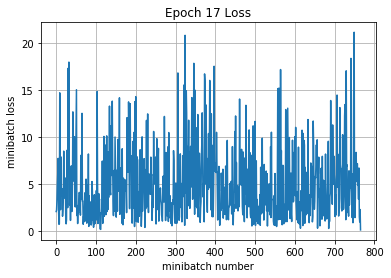

Iteration 13100: with minibatch training loss = 0.0306 and accuracy of 0.98
Iteration 13200: with minibatch training loss = 0.0296 and accuracy of 0.98
Iteration 13300: with minibatch training loss = 0.0508 and accuracy of 0.98
Iteration 13400: with minibatch training loss = 0.0265 and accuracy of 1
Iteration 13500: with minibatch training loss = 0.199 and accuracy of 0.94
Iteration 13600: with minibatch training loss = 0.153 and accuracy of 0.94
Iteration 13700: with minibatch training loss = 0.039 and accuracy of 0.98
Epoch 18, Overall loss = 0.0743 and accuracy of 0.976


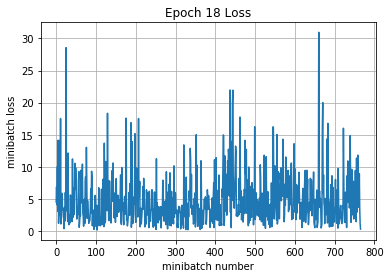

Iteration 13800: with minibatch training loss = 0.0645 and accuracy of 0.97
Iteration 13900: with minibatch training loss = 0.0782 and accuracy of 0.97
Iteration 14000: with minibatch training loss = 0.0729 and accuracy of 0.98
Iteration 14100: with minibatch training loss = 0.0468 and accuracy of 0.97
Iteration 14200: with minibatch training loss = 0.0793 and accuracy of 0.98
Iteration 14300: with minibatch training loss = 0.00563 and accuracy of 1
Iteration 14400: with minibatch training loss = 0.051 and accuracy of 0.97
Iteration 14500: with minibatch training loss = 0.0184 and accuracy of 1
Epoch 19, Overall loss = 0.0701 and accuracy of 0.978


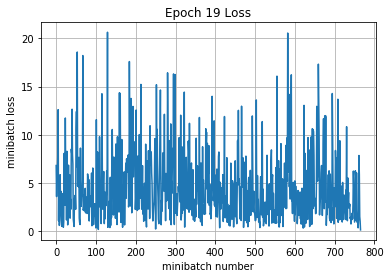

Iteration 14600: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 14700: with minibatch training loss = 0.0483 and accuracy of 0.98
Iteration 14800: with minibatch training loss = 0.189 and accuracy of 0.97
Iteration 14900: with minibatch training loss = 0.0813 and accuracy of 0.97
Iteration 15000: with minibatch training loss = 0.0476 and accuracy of 1
Iteration 15100: with minibatch training loss = 0.0158 and accuracy of 0.98
Iteration 15200: with minibatch training loss = 0.0429 and accuracy of 0.97
Iteration 15300: with minibatch training loss = 0.0535 and accuracy of 0.98
Epoch 20, Overall loss = 0.0693 and accuracy of 0.977


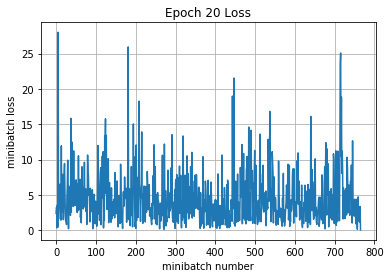

Validation
Epoch 1, Overall loss = 1.19 and accuracy of 0.767


(1.1948334999084473, 0.767)

In [5]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy

# Use this (https://stackoverflow.com/a/56511889) to avoid error: 
# `Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed 
# to initialize, so try looking to see if a warning log message was printed above.`
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
    
sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,20,64,100,train_step,True)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)